### Baseline Experiment

#### Overview
This scripts shows the implementation of the baseline experiment using MPNet embedding model (`paraphrase-mpnet-base-v2`) for sentence classification and the SetFit framework. 
This experiment is done to see the model's performance on non-augmented, original data, before any data augmentation techniques are applied.

/home/roland/Projects/saras_folder/myvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
<ipython-input-1-974043e296a8>:33: DeprecationWarning: `SetFit

Starting baseline training...

Epoch 1/3


***** Running training *****
  Num unique pairs = 799840
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.413600
50,0.351600
100,0.287400
150,0.249100
200,0.213000
250,0.185700
300,0.162000
350,0.150300
400,0.140800
450,0.123900


Validation Metrics after Epoch 1:
  AUC-ROC: 0.8363
  Precision: 0.7532
  Recall: 0.6891
  F1-Score: 0.7198
  F2-Score: 0.7011
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/baseline_mpnet/baseline_model_epoch_1

Epoch 2/3


***** Running training *****
  Num unique pairs = 799840
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.000100
50,0.005300
100,0.006200
150,0.003700
200,0.005200
250,0.005400
300,0.004400
350,0.004200
400,0.006900
450,0.005000


Validation Metrics after Epoch 2:
  AUC-ROC: 0.8516
  Precision: 0.7432
  Recall: 0.7214
  F1-Score: 0.7321
  F2-Score: 0.7257
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/baseline_mpnet/baseline_model_epoch_2

Epoch 3/3


***** Running training *****
  Num unique pairs = 799840
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.000000
50,0.004800
100,0.004900
150,0.003700
200,0.004300
250,0.004400
300,0.003800
350,0.003900
400,0.005400
450,0.004500


Validation Metrics after Epoch 3:
  AUC-ROC: 0.8257
  Precision: 0.7721
  Recall: 0.6657
  F1-Score: 0.7150
  F2-Score: 0.6846
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/baseline_mpnet/baseline_model_epoch_3


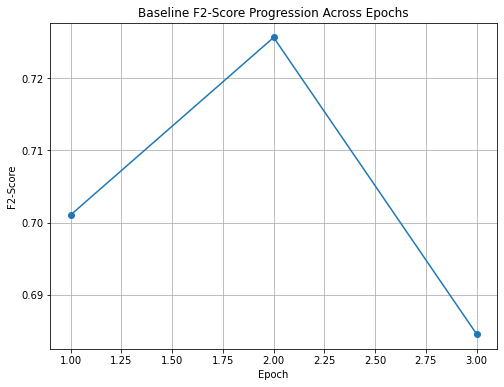

Baseline F2-Score progression chart saved at: /home/roland/Projects/saras_folder/Data_Splitting/baseline_mpnet/baseline_f2_scores_progression.png
Final baseline model saved at: /home/roland/Projects/saras_folder/Data_Splitting/baseline_mpnet/final_trained_baseline_model

Test Set Metrics (Baseline Final Evaluation):
AUC-ROC: 0.8411
Precision: 0.7469
Recall: 0.6995
F1-Score: 0.7224
F2-Score: 0.7085


: 

In [1]:
import os
import pandas as pd
from datasets import Dataset
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score
import matplotlib.pyplot as plt

train_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/train_split_original.csv'
val_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/val_split_original.csv'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_original.csv'

train_data = pd.read_csv(train_split_path)
val_data = pd.read_csv(val_split_path)
test_data = pd.read_csv(test_split_path)

train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

epoch_save_dir = "/home/roland/Projects/saras_folder/Data_Splitting/baseline_mpnet"
os.makedirs(epoch_save_dir, exist_ok=True)

model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20,
    column_mapping={"sentence_original": "text", "definition_sentence": "label"}
)

f2_scores = []

num_epochs = 3  
print("Starting baseline training...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    trainer.train()  

    val_labels = val_data['definition_sentence'].tolist()
    val_predictions = trainer.model.predict(val_data['sentence_original'].tolist())
    
    f2 = fbeta_score(val_labels, val_predictions, beta=2)
    val_auc = roc_auc_score(val_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

    print(f"Validation Metrics after Epoch {epoch + 1}:")
    print(f"  AUC-ROC: {val_auc:.4f}")
    print(f"  Precision: {val_precision:.4f}")
    print(f"  Recall: {val_recall:.4f}")
    print(f"  F1-Score: {val_f1:.4f}")
    print(f"  F2-Score: {f2:.4f}")
    
    f2_scores.append(f2)

    model_save_path_epoch = os.path.join(epoch_save_dir, f"baseline_model_epoch_{epoch + 1}")
    model.save_pretrained(model_save_path_epoch)
    print(f"Model saved at: {model_save_path_epoch}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(f2_scores) + 1), f2_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("F2-Score")
plt.title("Baseline F2-Score Progression Across Epochs")
plt.grid(True)
progress_chart_path = os.path.join(epoch_save_dir, "baseline_f2_scores_progression.png")
plt.savefig(progress_chart_path)
plt.show()
print(f"Baseline F2-Score progression chart saved at: {progress_chart_path}")

final_model_path = os.path.join(epoch_save_dir, "final_trained_baseline_model")
model.save_pretrained(final_model_path)
print(f"Final baseline model saved at: {final_model_path}")

test_labels = test_data['definition_sentence'].tolist()
test_predictions = model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

print("\nTest Set Metrics (Baseline Final Evaluation):")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"F2-Score: {test_f2:.4f}")


#### Graphs and Performance Visualization

The following graphs were generated to visualize the model's performance throughout the training process and evaluate its effectiveness.

In [5]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score
from datasets import Dataset
from setfit import SetFitModel

val_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/val_split_original.csv'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_original.csv'
model_dir = '/home/roland/Projects/saras_folder/Data_Splitting/baseline_mpnet'

val_data = pd.read_csv(val_split_path)
test_data = pd.read_csv(test_split_path)

epoch_metrics = []
num_epochs = 3

for epoch in range(1, num_epochs + 1):
    model_path = os.path.join(model_dir, f"baseline_model_epoch_{epoch}")
    model = SetFitModel.from_pretrained(model_path)
    
    val_labels = val_data['definition_sentence'].tolist()
    val_predictions = model.predict(val_data['sentence_original'].tolist())
    
    val_auc = roc_auc_score(val_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')
    val_f2 = fbeta_score(val_labels, val_predictions, beta=2)
    
    epoch_metrics.append({
        "Epoch": epoch,
        "AUC-ROC": val_auc,
        "Precision": val_precision,
        "Recall": val_recall,
        "F1-Score": val_f1,
        "F2-Score": val_f2
    })

final_model_path = os.path.join(model_dir, "final_trained_baseline_model")
final_model = SetFitModel.from_pretrained(final_model_path)

test_labels = test_data['definition_sentence'].tolist()
test_predictions = final_model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

epoch_metrics.append({
    "Epoch": "Test Split",
    "AUC-ROC": test_auc,
    "Precision": test_precision,
    "Recall": test_recall,
    "F1-Score": test_f1,
    "F2-Score": test_f2
})

metrics_df = pd.DataFrame(epoch_metrics)
print(metrics_df)


        Epoch   AUC-ROC  Precision    Recall  F1-Score  F2-Score
0           1  0.836309   0.753205  0.689150  0.719755  0.701074
1           2  0.851580   0.743202  0.721408  0.732143  0.725664
2           3  0.825653   0.772109  0.665689  0.714961  0.684560
3  Test Split  0.841093   0.746867  0.699531  0.722424  0.708512


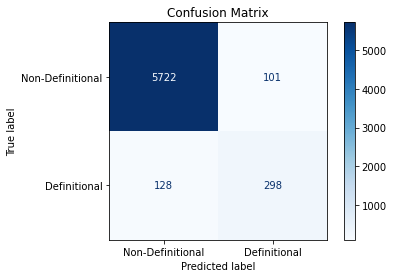


Final Model - Test Set Metrics:
AUC-ROC: 0.8411
Precision: 0.7469
Recall: 0.6995
F1-Score: 0.7224
F2-Score: 0.7085


In [2]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from setfit import SetFitModel
import matplotlib.pyplot as plt

test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_original.csv'
final_model_path = '/home/roland/Projects/saras_folder/Data_Splitting/baseline_mpnet/final_trained_baseline_model'

test_data = pd.read_csv(test_split_path)

final_model = SetFitModel.from_pretrained(final_model_path)

test_labels = test_data['definition_sentence'].tolist()
test_predictions = final_model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Definitional", "Definitional"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

print("\nFinal Model - Test Set Metrics:")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"F2-Score: {test_f2:.4f}")
